### OLAP Queries

#### Funções utilitárias

In [8]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

HOST = "10.101.151.25"
DATABASE = "tpd017"
USER = "tpd017"
PASSWORD = "tpd017" 

# Execute a single statement.
def execute_single_sql_statement(sql):
    conn = pg.connect(host=HOST,database=DATABASE, user=USER, password=PASSWORD)    
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close()    

# Return output of query in dataframe
def getSQLfromQuery(sql, params):
    conn = pg.connect(host=HOST,database=DATABASE, user=USER, password=PASSWORD)
    cur  = conn.cursor()    
    if len(params)==0:
        cur.execute(sql)
    else: 
        cur.execute(sql, params)
    data = cur.fetchall()
    colnames = [desc[0] for desc in cur.description]
    cur.close()
    conn.close()
    df=pandafy(data, colnames)
    return df

# Create a dataframe
def pandafy(rows, colnames):
    N=len(colnames)
    D={cn: [] for cn in colnames}
    for row in rows:
        for i in range(N): D[colnames[i]].append(row[i])
    pdfy=pd.DataFrame(D)
    return pdfy


3. **Assumindo que os diferentes níveis de urbanismo nos municípios afetam a quantidade de tráfego nos mesmos, esse aumento também vai ocorrer no número de acidentes e na severidade dos mesmos?** 


* **Objetivo da interrogação**: Análise e visualização, para cada nível de urbanismo, do número de acidentes, e da distribuição da severidade nos mesmos, de modo a entender padrões à medida que o urbanismo aumenta.
* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Location (atributo `LocationKey`)
    * Location: para recolha dos diferentes níveis de urbanismo (atributo `UrbanRuralClassification`)
    * Severity: para recolha das diferentes severidades dos acidentes (atributo-chave `SeverityKey`)
* **Relevância para quais processos?**
    * Seguradoras: adequação de valores através da prevalência de determinados acidentes em certas zonas
    * Policiamento: dado o número de acidentes, adaptação de meios de vigiliância e cooperação
    * Estruturas de controlo de tráfego: recolha de informação para identificação de zonas mais vulneráveis

**Interrogação**:

``
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
``


In [2]:
SQL="""
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
"""

df = getSQLfromQuery(SQL, ())

In [3]:
df['urban_rural_classification'] = df['urban_rural_classification'].apply(lambda x: x.rstrip())
df

,severitykey,urban_rural_classification,number_of_accidents
0,1,Large Central Metro,5
1,2,Large Central Metro,12664
2,3,Large Central Metro,5840
3,4,Large Central Metro,233
4,1,Large Fringe Metro,4
5,2,Large Fringe Metro,4504
6,3,Large Fringe Metro,2374
7,4,Large Fringe Metro,297
8,1,Medium Metro,4
9,2,Medium Metro,5234


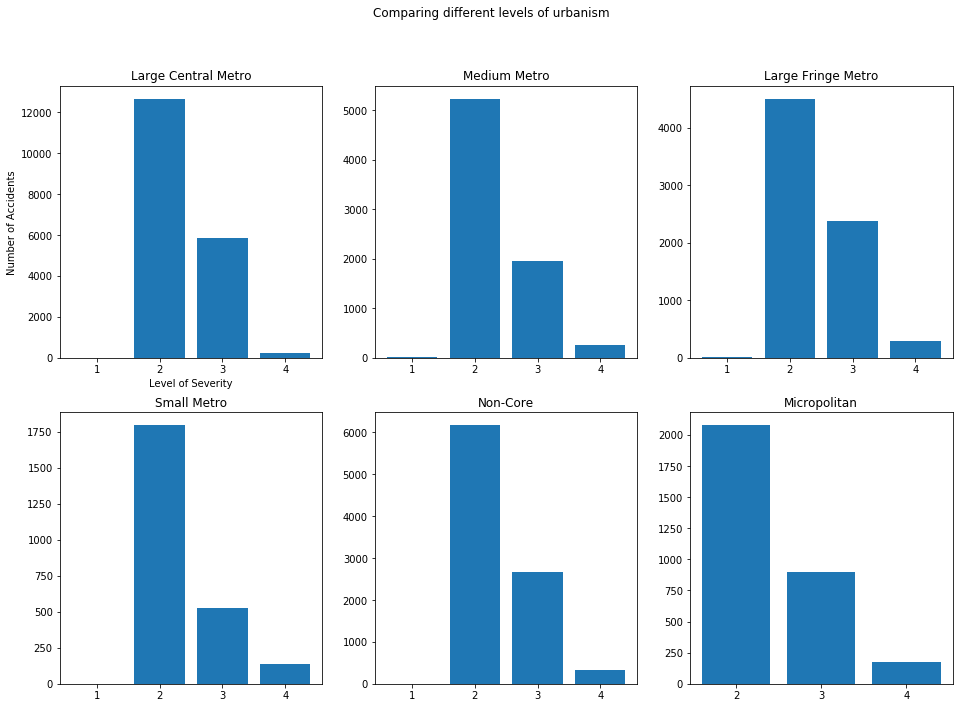

In [4]:
classes = list(set(df['urban_rural_classification'].values))
fig, axs = plt.subplots(2,3, figsize=(16,11))
fig.suptitle('Comparing different levels of urbanism')

for i, ax in enumerate(fig.axes):
    test = df.loc[df['urban_rural_classification'] == classes[i]].drop(columns=['urban_rural_classification'])
    ax.set_xticks(test['severitykey'].values)
    ax.bar(test['severitykey'].values, test['number_of_accidents'].values)
    ax.set_title(classes[i])
    if i == 0: 
        ax.set_xlabel("Level of Severity")
        ax.set_ylabel("Number of Accidents")
plt.show()

4. **Assumindo que a condição de 'piso escorregadio' influi negativamente nos acidentes, qual será o impacto de algumas condições metereológicas tipicamente associadas a esta condição na distância e duração média dos acidentes verificados?**


* **Objetivo da interrogação**: Análise e visualização, para os atributos metereológicos selecionados, a duração média e a distância média dos acidentes, de modo a entender os padrões que mais contribuem para acidentes tipicamente associados a piso escorregadio.

* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Weather (atributo `weather_key`)
    * Weather: para recolha dos diferentes atributos metereológicos (atributos `precipitation`,`weathercondition`,`humidity` )
* **Relevância para quais processos?**
    * Estruturas de controlo de tráfego: estudo das condições e emissão de alertas aos condutores.

**Interrogação**:

``
Select weather_dimension.precipitation as precipitation, 
		weather_dimension.weather_condition as weathercondition, 
		weather_dimension.humidity as humidity, 
		avg(facts_table.distance) as average_distance,
		avg(facts_table.duration) as average_duration,
		count(*)
from facts_table, weather_dimension
where facts_table.weatherkey = weather_dimension.weather_key 
       and weather_dimension.precipitation not like '%Unknown%'
	   and weather_dimension.weather_condition not like '%Unknown%'
	   and weather_dimension.humidity not like '%Unknown%'
GROUP BY precipitation, weathercondition, humidity
order by average_duration desc
``


In [5]:
SQL="""
select weather_dimension.precipitation as precipitation, 
        weather_dimension.weather_condition as weathercondition, 
        weather_dimension.humidity as humidity, 
        avg(facts_table.distance) as average_distance,
        avg(facts_table.duration) as average_duration
from facts_table, weather_dimension
where facts_table.weatherkey = weather_dimension.weather_key 
       and weather_dimension.precipitation not like '%Unknown%'
       and weather_dimension.weather_condition not like '%Unknown%'
       and weather_dimension.humidity not like '%Unknown%'
GROUP BY precipitation, weathercondition, humidity
order by average_duration desc
"""

df = getSQLfromQuery(SQL, ())

In [6]:
df['precipitation'] = df['precipitation'].apply(lambda x: x.rstrip())
df['weathercondition'] = df['weathercondition'].apply(lambda x: x.rstrip())
df['humidity'] = df['humidity'].apply(lambda x: x.rstrip())

df

,precipitation,weathercondition,humidity,average_distance,average_duration
0,(Light) rate <= 0.1,Cloudy / Windy,(Very High) rate > 75.0,0.125118,06:43:37.470589
1,(Light) rate <= 0.1,Mostly Cloudy,(Very High) rate > 75.0,0.270676,06:13:49.174920
2,(Moderate) 0.1 < rate <= 0.3,Smoke,(Medium) 25.0 < rate <= 50.0,0.054000,06:00:00
3,(Moderate) 0.1 < rate <= 0.3,Smoke,(High) 50.0 < rate <= 75.0,0.110000,06:00:00
4,(Light) rate <= 0.1,Partly Cloudy / Windy,(Low) rate <= 25.0,0.508000,03:56:08.500000
...,...,...,...,...,...
233,(Light) rate <= 0.1,Light Rain / Windy,(High) 50.0 < rate <= 75.0,0.000000,00:29:24
234,(Violent) rate > 2.0,Heavy Rain,(Very High) rate > 75.0,0.000000,00:29:20
235,(Violent) rate > 2.0,Heavy Thunderstorms and Rain,(Very High) rate > 75.0,0.750000,00:29:15
236,(Light) rate <= 0.1,Showers in the Vicinity,(Medium) 25.0 < rate <= 50.0,0.341000,00:28:51


In [11]:
df['average_duration'] = df['average_duration'].astype(np.int64)

table = pd.pivot_table(df, values=['average_distance','average_duration'],margins=True, index=['precipitation', 'weathercondition', 'humidity'], aggfunc={'average_distance':np.mean, 'average_duration': np.mean})

table['average_duration'] = pd.to_timedelta(table['average_duration'])

table

average_distance  \
precipitation              weathercondition humidity                                         
(Heavy) 0.39 < rate <= 2.0 Clear            (High) 50.0 < rate <= 75.0            0.188357   
                                            (Low) rate <= 25.0                    0.006667   
                                            (Medium) 25.0 < rate <= 50.0          0.049300   
                                            (Very High) rate > 75.0               1.558053   
                           Cloudy           (Very High) rate > 75.0               1.695000   
...                                                                                    ...   
(Violent) rate > 2.0       Overcast         (Medium) 25.0 < rate <= 50.0          0.010000   
                                            (Very High) rate > 75.0               0.191000   
                           Partly Cloudy    (High) 50.0 < rate <= 75.0            0.029333   
                                            (Very High) rate > 75.0               0.088000   
All                                                                               0.606243   

                                                                         average_duration  
precipitation              weathercondition humidity                                       
(Heavy) 0.39 < rate <= 2.0 Clear            (High) 50.0 < rate <= 75.0    01:11:32.964286  
                                            (Low) rate <= 25.0            00:30:37.666667  
                                            (Medium) 25.0 < rate <= 50.0  00:37:50.200000  
                                            (Very High) rate > 75.0       00:32:35.315789  
                           Cloudy           (Very High) rate > 75.0       01:11:53.500000  
...                                                                                   ...  
(Violent) rate > 2.0       Overcast         (Medium) 25.0 < rate <= 50.0         00:44:30  
                                            (Very High) rate > 75.0              00:29:48  
                           Partly Cloudy    (High) 50.0 < rate <= 75.0    02:24:48.666667  
                                            (Very High) rate > 75.0       03:14:47.500000  
All                                                                       01:31:26.931142  

[239 rows x 2 columns]